# The Outcasts of Hollywood 
### Ada CS-401 Project 
### Autumn 2022 - xxdatasiencesxx

#### SUMMARY: 
1. Genders and ethnicities of the actors (question 3)
    1. Movie revenue distribution in main character database versus cmu movies
    1. Genre distribution in cmu database versus main character database
    1. Are movies genres and gender of the lead role related?
    1. Adding the ethnicity of actors (when available)
1. Gender of the crew (question 5)
    1. Data preprocessing
    1. Are the proportions of movies with women in the crew or created by men different ? 
    1. Does the proportion of movies with women in the crew change with time ?
1. Revenue comparisons (question 4)
    1. In terms of the gender of the main actor
    1. In terms of the gender of the crew 
    1. OLS to predict the revenue
1. NLP (question 1 and 2)

# 0 - Data Wrangling

In [ ]:
!pip install lxml
!pip install spacy

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import gzip
import glob, os
from tqdm.auto import tqdm
tqdm.pandas()
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as sts 
#NLP libraries
import spacy, nltk, gensim, sklearn
#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer

import plotly.graph_objects as go
import plotly.express as px
import chart_studio
import chart_studio.tools as tls
import chart_studio.plotly as py
import ast

path = '../MovieSummaries/'

In [ ]:
# Load various datasets
movies_db = pd.read_pickle(path + 'movies_db.pickle')
name_clusters = pd.read_pickle(path + 'name_clusters.pickle')
crew_basic = pd.read_csv(path + "imdb_crew.tsv", sep="\t")
name_basics = pd.read_csv(path + "imdb_name_basics.tsv", sep="\t")
movie_basics = pd.read_csv(path + "imdb_movie_basics.tsv", sep="\t", low_memory=False)
directors_sex = pd.read_csv(path + "git_all_directors_gender.csv", sep=",")
mainchar_budget = pd.read_csv(path + "kaggle_movies.csv", sep=",")
ethnicity_query = pd.read_csv(path + "ethnicity_query.csv", sep=';')
characters_db = pd.read_pickle(path + "characters_db.pickle")

In [ ]:
# For this project, we will focus on american movies
movies_usa = movies_db[movies_db['countries'].apply(lambda x: '"/m/09c7w0": "United States of America"' in x)]
print(f"Out of our database, we have {len(movies_usa)} american movies.")
print(f"We ignore {len(movies_db)-len(movies_usa)} movies from the original dataset.")

In [ ]:
movies_usa.head(1)

# 1 - Gender and ethnicities of the actors 

The following analysis will try to give an answer to two questions. 
1. Are the genre of a movie and the ethnicity of the lead role correlated?
2. Are the genre of a movie and the gender of the lead role correlated?

In [153]:
# add the main character to the movies_crew database
# load dataset of movies with main character from 1980 onwards
main_char = mainchar_budget
main_char.drop_duplicates()
print(f"We are working with a dataset of {len(main_char)} movies for main characters.")
main_char.head(1)

We are working with a dataset of 7668 movies for main characters.


,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0


In [154]:
len_movies_usa = len(movies_usa[movies_usa['release']> '1980-12-06'])
len_main_char = len(main_char)
print(f"By using the main character's database, we lose {len_movies_usa - len_main_char} movies.")
print(f"This is because not all movies in movies_crew are present in the main_char database.")

By using the main character's database, we lose 9801 movies.
This is because not all movies in movies_crew are present in the main_char database.


## 1.1 - Movie revenue distribution in main character database versus cmu movies

Let us investigate significant differences between the main character dataset we are using and the cmu movie database provided to us for the project.

The role of the following analysis will be to see if our results can be biased based on the movie revenues in the datasets.

For example, if most movies in the main character database have a higher average revenue, then we can say our analyis mostly applies to movies with high revenue and can be biased for movies of lower revenue.

The revenue distribution looks simmilar.
However, the main character database does seem to have more movies with higher revenue.


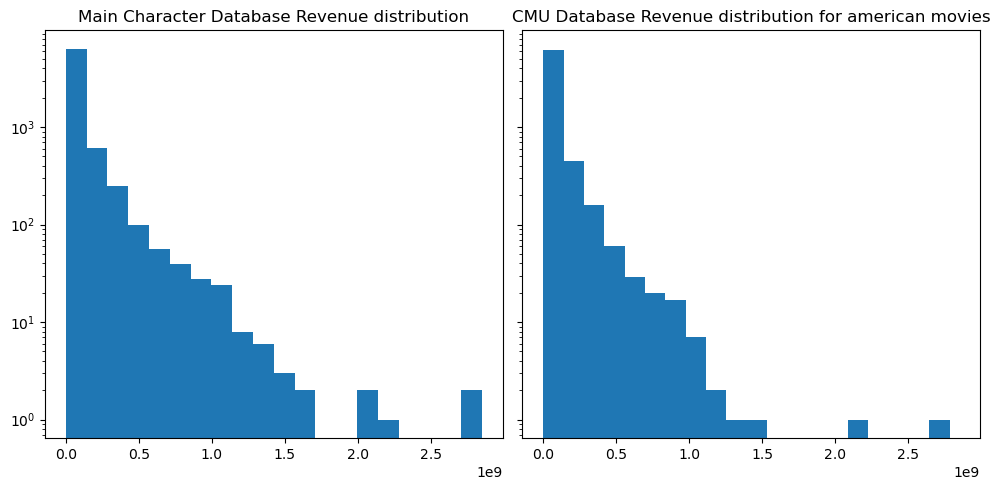

In [155]:
# plot histograms of the revenue of movies in both databases

ax = sns.histplot(main_char['gross'], kde=True, stat='density', label='Main Character database')
ax = sns.histplot(movies_usa['revenue'], kde=True, stat='density', label='CMU database')
ax.set(title='Movie Revenue distribution between two datasets',xlabel='Revenue')
ax.semilogx()
plt.legend()
plt.show()

In [156]:
print("Let us check if the different between the revenues is significant.")

# let us first compute the mean
print(f"The mean revenue in the main character database is {main_char['gross'].mean()}.")
print(f"The mean revenue for the movie metadata database for american movies is {movies_usa[movies_usa['release']> '1980-12-06']['revenue'].mean()}")
print(f"On average, the revenue of movies in the main character database is {round(movies_usa['revenue'].mean()/main_char['gross'].mean(),4)*100}% higher than the revenue of cmu movies.")                                                                                                                                              

Let us check if the different between the revenues is significant.
The mean revenue in the main character database is 78500541.01778312.
The mean revenue for the movie metadata database for american movies is 66140256.468948744
On average, the revenue of movies in the main character database is 69.46% higher than the revenue of cmu movies.


In [157]:
# we will use hypothesis testing to see if the revenue of movies in one dataset is bigger than the other
# 'Ho = the distribution is the same' is the hypothesis

print(stats.ttest_ind(main_char['gross'], movies_usa[movies_usa['release']> '1980-12-06']['revenue'], nan_policy='omit'))

Ttest_indResult(statistic=4.506366155618769, pvalue=6.653073527605449e-06)


#### Observations from movie revenue analysis
The p-value is much smaller than 0.05, meaning we can safely reject the null hypothesis that the mean revenues for movies from the two databases are the same.
The value of the test statistic is positive, hence, the mean revenue of movies in the main character dataset is larger.
Therefore, analysis done in this study applies on american movies released after June 1980 with on average high revenue.

## 1.2 - Genre distribution in cmu database versus main character database

Let us investigate more significant differences between the main character dataset we are using and the cmu movie database provided to us for the project. 

The role of the following analysis will be to see if our results can be biased based on the prevalence of certain movie genres in the dataset.

For example, if most movies in the main character database are thrillers, then we can say our analyis mostly applies to thrillers and can be biased for movies of other genres.

In [158]:
# Now get us see if some movie genres are over or under represented in one database compared to the other
# Let us store the genre distribution of the main character movie database in a dataframe

# initialize data frame

# create an array of all the genres 
genres = main_char['genre'].unique()

# initialize data frame
main_char_genres = pd.DataFrame(columns=['movie_number_main_char', 'movie_%_main_char'], 
                  index = [genres])

# fill dataframe with the number and proportion 
for genre in range(len(genres)):
    
    main_char_genres.iat[genre,0] = main_char[main_char['genre']==genres[genre]]['genre'].count()
    main_char_genres.iat[genre,1] = round(main_char_genres.iat[genre,0]/len(main_char)*100,2)
    
main_char_genres.head()

,movie_number_main_char,movie_%_main_char
Drama,1518,19.8
Adventure,427,5.57
Action,1705,22.24
Comedy,2245,29.28
Horror,322,4.2


In [159]:
genres = np.array(['Drama', 'Adventure', 'Action', 'Comedy', 'Horror', 'Biography',
       'Crime', 'Fantasy', 'Family', 'Science Fiction', 'Animation', 'Romance',
       'Music', 'Western', 'Thriller', 'History', 'Mystery', 'Sport',
       'Musical'])

movies_usa_genres = pd.DataFrame(columns=['movie_number_usa', 'movie_%_usa'], 
                  index = [genres])

# fill dataframe with the number and proportion 
for genre in range(len(genres)):
    
    movies_usa_genres.iat[genre,0]=movies_usa[movies_usa['genres'].apply(lambda x: genres[genre] in x)]['genres'].count()
    

for genre in range(len(genres)):
    movies_usa_genres.iat[genre,1]= round(movies_usa_genres.iat[genre,0]/sum(movies_usa_genres['movie_number_usa']) *100,2)

#movies_usa_genres.sort_values(by = 'movie_number')    
movies_usa_genres.head()

,movie_number_usa,movie_%_usa
Drama,13375,18.88
Adventure,5477,7.73
Action,5246,7.4
Comedy,10973,15.49
Horror,3050,4.3


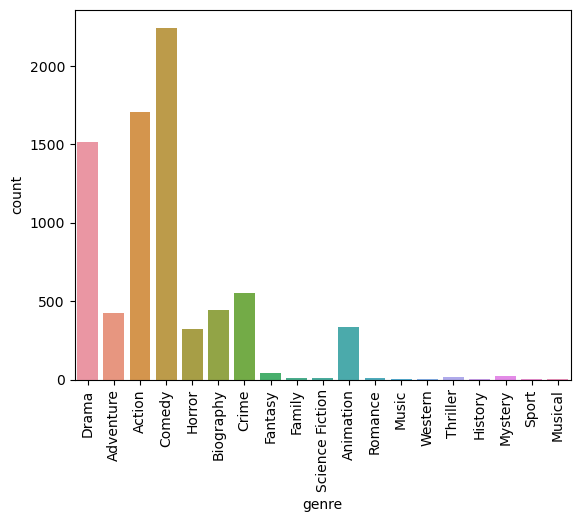

In [160]:
#movies_usa_genres['genre'] = movies_usa_genres.index
# creating the bar plot
ax = sns.countplot(data=main_char, x="genre")
ax.set_xticklabels(labels=genres,rotation=90);

The genre distribution of the two movies looks very different.


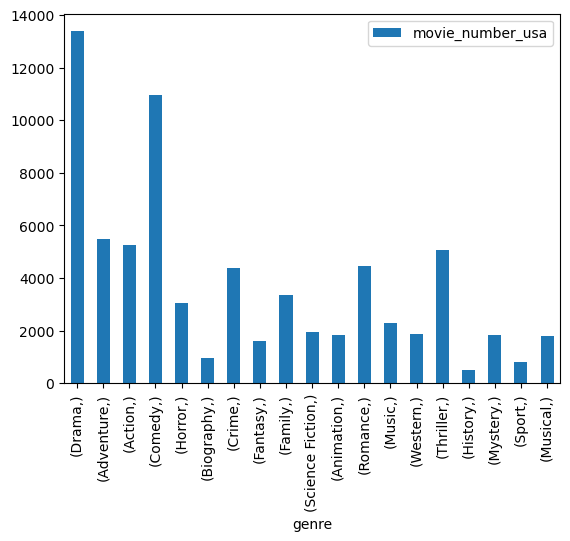

In [161]:
movies_usa_genres['genre']=movies_usa_genres.index
ax = movies_usa_genres.plot.bar(x='genre', y='movie_number_usa', rot=90) 
print("The genre distribution of the two movies looks very different.")

In [ ]:
# plot that will go onto the website page
import plotly.express as px

# create dataframe with number of movies per movie genre
genre_df = main_char.groupby(by=["genre"]).size().reset_index(name="number of movies")

# plot genre distribution
fig = px.bar(genre_df, y='number of movies', x='genre',text_auto='.2s', 
             title = "Genre distribution of movies in Study")
fig.show(renderer = "notebook")

In [162]:
# let us compare the proportions:
genre_compare = pd.concat([movies_usa_genres[['movie_%_usa']] ,main_char_genres[['movie_%_main_char']] ], axis = 1)
genre_compare['movie_%_main_char'][9] = 0.13
genre_compare['difference'] = genre_compare['movie_%_usa']-genre_compare['movie_%_main_char']
genre_compare = genre_compare.sort_values(by ='difference', ascending = 0)
genre_compare.head(19)

,movie_%_usa,movie_%_main_char,difference
Thriller,7.18,0.21,6.97
Romance,6.32,0.13,6.19
Family,4.72,0.14,4.58
Music,3.22,0.01,3.21
Science Fiction,2.74,0.13,2.61
Western,2.63,0.04,2.59
Musical,2.55,0.03,2.52
Mystery,2.61,0.26,2.35
Adventure,7.73,5.57,2.16
Fantasy,2.25,0.57,1.68


#### Observations from genre distribution Analysis
Our analysis dataset has a smaller proportion of drama, thriller, Romance, Family and Science fiction movies than the original dataset, as well has a much much bigger proportion of Action, Comedy, and Biography movies.

Therefore, we can say that our analysis is mostly valid for Action, Comedy and Biography movies, but very innacurate for Thrillers, Romance and Family movies. This is a limitation of our study.

In [163]:
print(f"We are supposed to have about {len(main_char)} movies until the end.")

We are supposed to have about 7668 movies until the end.


In [164]:
# add the main characters to the movies_usa dataset by merge 
main_char.drop(columns = ['runtime'],inplace = True)
movies_usa_lead = pd.merge(movies_usa, main_char, how='inner', left_on='name', right_on='name')
movies_usa_lead.head(1)

,wiki_movieID,freebase_movieID,name,release,revenue,runtime,languages,countries,genres,rating,...,released,score,votes,director,writer,star,country,budget,gross,company
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",R,...,"August 24, 2001 (United States)",4.9,52000.0,John Carpenter,Larry Sulkis,Natasha Henstridge,United States,28000000.0,14010832.0,Screen Gems


In [165]:
print(f"There are {len(movies_usa[movies_usa['release']> '1980-12-06'])-len(main_char[main_char.index<6445])} movies lost when we use the main_char dataset")

There are 11024 movies lost when we use the main_char dataset


In [166]:
print(f"Length after merge: {len(movies_usa_lead)}.")
print(f"We lose {len(main_char[main_char.index<6445]) - len(movies_usa_lead)} movies of missing movies in either dataset or different spelling of the movie title.")

Length after merge: 6151.
We lose 294 movies of missing movies in either dataset or different spelling of the movie title.


In [167]:
# characters metadata dataset with all characters and their gender
characters_db.head(1)

,wiki_movieID,freebase_movieID,release,char_name,dob,gender,height,ethnicity,act_name,age_amr,freebase_charmap
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw


In [168]:
characters_db.drop(columns = ['char_name', 'release'], inplace = True)
#characters_db.columns

In [169]:
movies_usa_gender = pd.merge(movies_usa_lead, characters_db, how = 'inner', right_on= ['wiki_movieID', 'act_name'], left_on = ['wiki_movieID', 'star'])
movies_usa_gender.head(2)

,wiki_movieID,freebase_movieID_x,name,release,revenue,runtime,languages,countries,genres,rating,...,company,freebase_movieID_y,char_name,dob,gender,height,ethnicity,act_name,age_amr,freebase_charmap
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",R,...,Screen Gems,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
1,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",R,...,Pressman Film,/m/02wjqm,Fox,1943-03-31,M,1.83,/m/01qhm_,Christopher Walken,56.0,/m/02vbmy1


## 1.3 - Are movies genres and gender of the lead role related?

### 1.3.1 - Naïve analysis 

In [74]:
# let us first build a contingency table for analysis 

gender_contingency = pd.crosstab(movies_usa_gender['gender'], 
                            movies_usa_gender['genre'],
                                margins = False)
gender_contingency.head()

genre,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller,Western
gender,,,,,,,,,,,,,,,
F,111,57,30,57,464,66,296,5,9,88,5,2,1,4,0
M,1021,227,166,159,1145,301,554,2,23,108,12,4,6,2,3


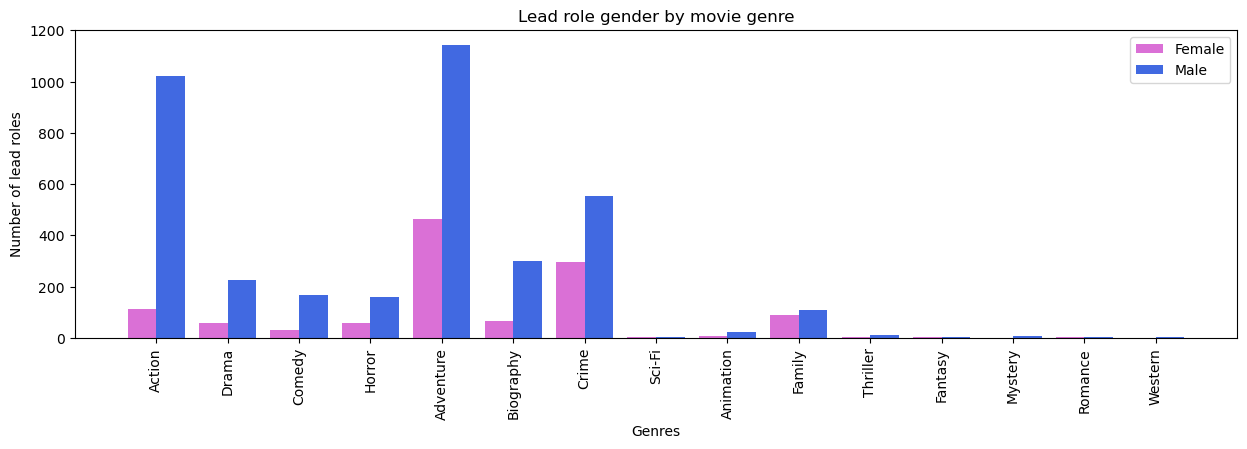

It looks like male actors systemacically have a higher chance at the lead role, with the differences depending upon which movie genre we look at. For example, for action movies, men are far more likely to have the lead role than women, whereas in drama movies, this difference is less stark.


In [75]:
# let us first visualize this contingency table

X = movies_usa_gender['genre'].unique()
Y_female = gender_contingency.loc['F',:]
Y_male = gender_contingency.loc['M',:]
X_axis = np.arange(len(X))

plt.figure(figsize=(15,4))
plt.bar(X_axis-0.2, Y_female, 0.4, label = 'Female', color = 'orchid')
plt.bar(X_axis+0.2, Y_male, 0.4, label = 'Male', color = 'royalblue')

plt.xticks(X_axis, X, rotation = 90)
plt.xlabel("Genres")
plt.ylabel("Number of lead roles")
plt.title("Lead role gender by movie genre")
plt.legend()
plt.show()

print("It looks like male actors systemacically have a higher chance at the lead role, with the differences depending upon which movie genre we look at. For example, for action movies, men are far more likely to have the lead role than women, whereas in drama movies, this difference is less stark.")

### 1.3.2 - Statistical analysis 
**Note:** For some movies genres (Sci-Fi, Family, Thriller, Fantasy, Mysterym, Romance and Western) we don't have enough data points to do a firm analysis, hence, we will drop them and focus our analysis for Drama, Action, Comedy, Crime, Biography, Adventure, Animation and Horror movies. This is a limitation of our study.

In [78]:
# now let us do more robust tests with statistical methods
# get us look at the correlation between the gender of the lead role and the genre of a movie

gender_contingency = gender_contingency[['Drama','Action','Comedy','Crime','Biography','Adventure','Animation','Horror']]
genres = gender_contingency.columns
# we will use Cramer's V method to calculate the correlation coefficient between the categorical variables
dataset = np.array(gender_contingency)

X2 = stats.chi2_contingency(dataset, correction=False)[0]
N = np.sum(dataset)
minimum_dimension = min(dataset.shape)-1
  
# Calculate Cramer's V
result = np.sqrt((X2/N) / minimum_dimension)
print(f"R = {result}")
print("The correlation coefficient R is high enough to investigate further.")

R = 0.23370052243721776
The correlation coefficient R is high enough to investigate further.


In [79]:
# let us use the chi-squared test 

dataset = np.array(gender_contingency)

stat, p_value, dof, expected_freq = stats.chi2_contingency(dataset)
print(f"Test statistic = {stat}, p-value = {p_value}")
print("The p-value is much smaller than 0.05, so we can reject the null hypothesis that the gender of the lead actor isn't related genre of the movie. ")

Test statistic = 264.8872808090283, p-value = 1.8714237807602342e-53
The p-value is much smaller than 0.05, so we can reject the null hypothesis that the gender of the lead actor isn't related genre of the movie. 


In [80]:
# now let is try to compare the exèected frequencies and observed frequencies and visualise the difference
# we will plot them side by side 

# creating a new contingency table out of expected frequencies given by the shi-squared test
gender_contingency_x2 = pd.DataFrame(expected_freq, columns = genres, index = ['F','M'])

# converting frequencies into percentages
gender_contingency_x2 = gender_contingency_x2.apply(lambda x: x/sum(x))
gender_contingency = gender_contingency.apply(lambda x: x/sum(x))

# preparing X and Y values for bar plots
X = genres
Y_female = gender_contingency.loc['F',:]
Y_male = gender_contingency.loc['M',:]
X_axis = np.arange(len(X))

Y_female_exp = gender_contingency_x2.loc['F',:]
Y_male_exp = gender_contingency_x2.loc['M',:]

contingency_diff = gender_contingency-gender_contingency_x2
Y_female_diff = contingency_diff.loc['F',:]
Y_male_diff = contingency_diff.loc['M',:]

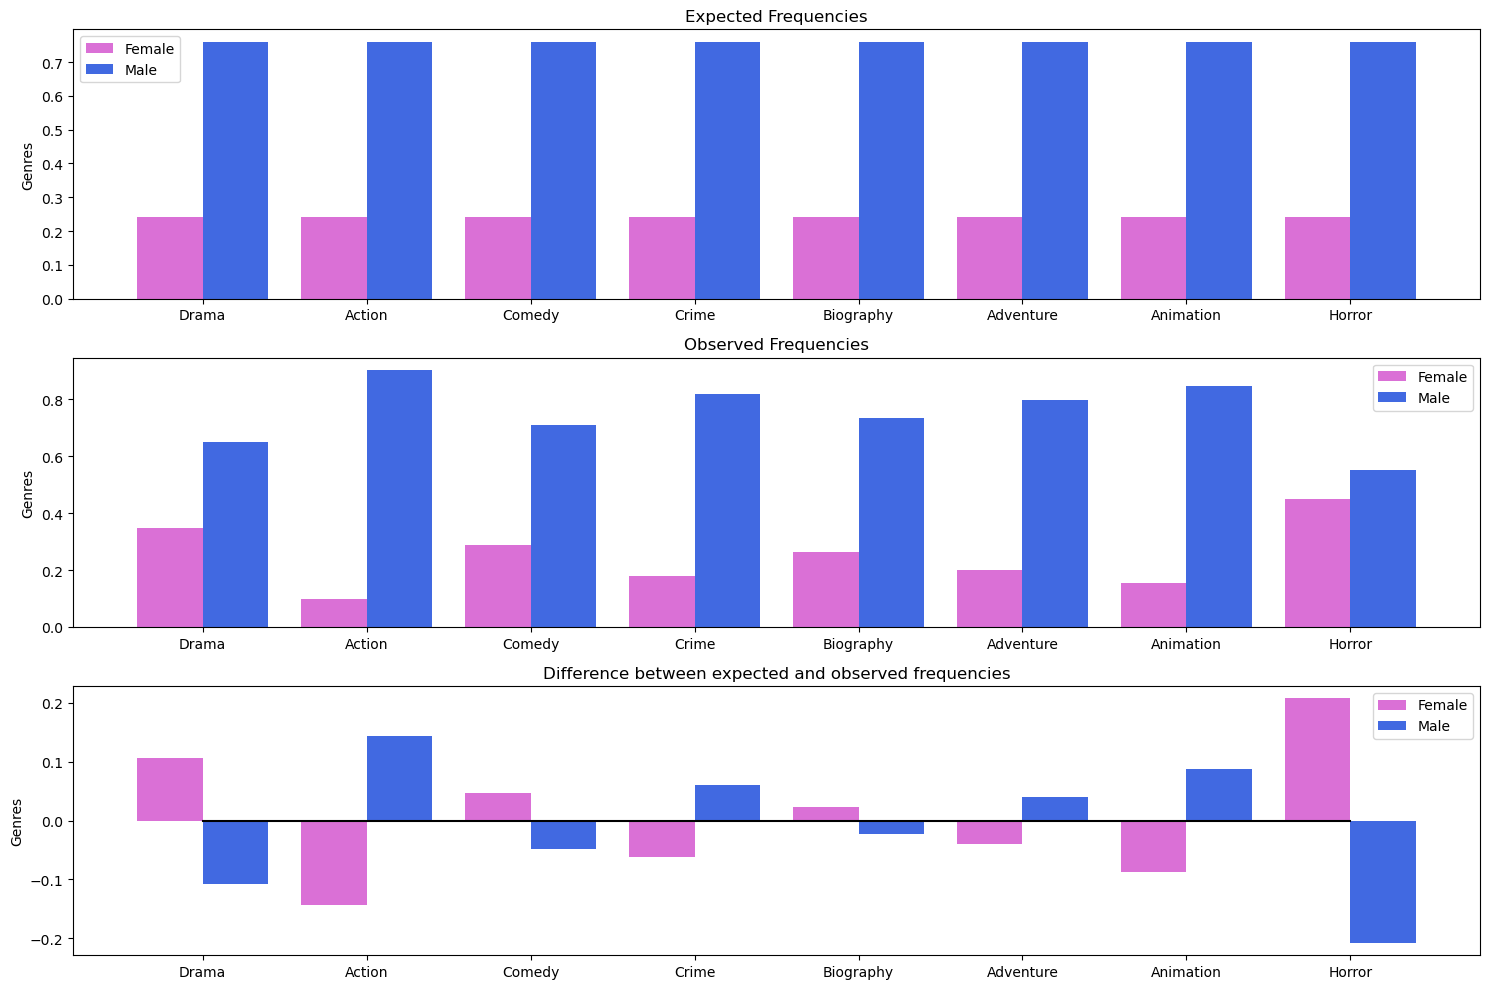

In [81]:
# let is visualise the difference between the expected values and the observed values 
# the expected values in a chi-squared test are the values we would expect if the null hypothesis were true
# meaning the frequencies we could expect if the gender of the lead actor and movie genre were not correlated

# plot 
fig, ax = plt.subplots(3,1, figsize=(15,10))

ax[0].bar(X_axis-0.2, Y_female_exp, 0.4, label = 'Female', color = 'orchid')
ax[0].bar(X_axis+0.2, Y_male_exp, 0.4, label = 'Male', color = 'royalblue')

ax[1].bar(X_axis-0.2, Y_female, 0.4, label = 'Female', color = 'orchid')
ax[1].bar(X_axis+0.2, Y_male, 0.4, label = 'Male', color = 'royalblue')

ax[2].bar(X_axis-0.2, Y_female_diff, 0.4, label = 'Female', color = 'orchid')
ax[2].bar(X_axis+0.2, Y_male_diff, 0.4, label = 'Male', color = 'royalblue')
y = 0*X_axis
ax[2].plot(X_axis,y,'-k')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Genres')
ax[0].set_title('Expected Frequencies')
ax[0].set_xticks(X_axis, genres)
ax[0].legend()
ax[1].set_ylabel('Genres')
ax[1].set_title('Observed Frequencies')
ax[1].set_xticks(X_axis, genres)
ax[1].legend()
ax[2].set_ylabel('Genres')
ax[2].set_title('Difference between expected and observed frequencies')
ax[2].set_xticks(X_axis, genres)
ax[2].legend()
plt.tight_layout()

####  Observations:
Without any correlation between the gender of the lead role and movies genre, men are expected to lead ≃ 75% of movies of all genres and women are expected to lead ≃ 25% of movies across all genres(This is because men are generally occupy the main role in movies more often than women). However, the observed values differ from this prediciton. On average, women occupy 25% of the lead roles in movies and men occupy 75% of them.

**Drama Films:** In Drama films, women occupy the lead role ≃ 35% of the time and men ≃ 65% of the time. Comparing with the expected values, this means american cinema is more likely to choose women as lead role in Drama movies than men than average.

**Comedy Films:** In Comedy films, women occupy the lead role ≃ 30% of the time and men ≃ 70% of the time. Comaring with the expected frequencies, american cinema is more likely to choose women as lead role in Comedy movies than men than average.

**Action Films:** In Action films, men occupy the lead role more than 90% of the time while women occupy it less than 10% of the time. Comparing this to the expected values, american cinema is more likely to choose men as their lead role in action movies than average.

**Crime Films:** In Crime films, men occupy the lead role more than 80% of the time while women occupy it less than 20% of the time. Comparing is to the expected frequencies, american cinema is more likely to choose men as their lead role in crime movies on average.

**Biography Films:** In Biography films, men occupy the lead role about 70% of the time while women occupy it about 30% of the time. Comparing this to the expected values, Biography films star women a bit more than average.

**Adventure Films:** In Adventure films, men occupy the lead role more than 70% of the time while women occupy it less than 30% of the time. Comparing this to the expected values, Adventure films star women a bit more than average.

**Horror Films:** Horror films seem to do the best in terms of gender distribution of main roles. Women occupy the lead role 44% of the tie while men occupy it 55% of the time. Comparing this to the expected values, Horror movies are much more likely to portray women than men compared to average.



## 1.4 - Adding the ethnicity of actors (when available)
In this section, we will use the cum character database that has the freebaseID of actor's ethnicty, and match it with the ethnicities in our ethnicity query database that contains the ethnicity corresponding to every freebaseID code.

In [82]:
## adding ethnicity of every main actor 

# load ethnicity query database containing corresponding ethnicity of every freebaseID code

ethnicity_query.rename(columns = {'name': 'ethnicity_original'}, inplace = True)
ethnicity_query.rename(columns = {'freebaseID': 'ethnicity_freebaseID'}, inplace = True)
ethnicity_query.drop(columns = ['item'], inplace = True)
ethnicity_query.head(1)

,ethnicity_freebaseID,ethnicity_original,ethnicity
0,/m/038cy,Germanic peoples,NaN


In [83]:
# load characters metadata dataset with all characters and their eithnicity code 
characters_db.head(1)

,wiki_movieID,freebase_movieID,dob,gender,height,ethnicity,act_name,age_amr,freebase_charmap
0,975900,/m/03vyhn,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw


In [84]:
# add correct ethnicity in characters_db instead of code with help of ethnicity_query table
characters_db = pd.merge(characters_db, ethnicity_query, how='inner', left_on='ethnicity', right_on='ethnicity_freebaseID')
characters_db.drop(columns = ['ethnicity_x'], inplace = True)
characters_db.rename(columns = {'ethnicity_y': 'ethnicity'}, inplace = True)
characters_db.drop(columns = ['height'], inplace = True)
characters_db.head(1)

,wiki_movieID,freebase_movieID,dob,gender,act_name,age_amr,freebase_charmap,ethnicity_freebaseID,ethnicity_original,ethnicity
0,975900,/m/03vyhn,1959-03-09,M,Rodney A. Grant,42.0,/m/0bgchrs,/m/064b9n,Omaha people,Native American


In [85]:
#characters_db.drop(columns = ['char_name', 'release'], inplace = True)

In [86]:
print(len(movies_usa_lead))
movies_usa_ethnicity = pd.merge(movies_usa_lead, characters_db, how = 'inner', right_on= ['wiki_movieID', 'act_name'], left_on = ['wiki_movieID', 'star'])
print(len(movies_usa_ethnicity))
movies_usa_ethnicity.head(1)

6151
1741


,wiki_movieID,freebase_movieID_x,name,release,revenue,runtime,languages,countries,genres,rating,...,company,freebase_movieID_y,dob,gender,act_name,age_amr,freebase_charmap,ethnicity_freebaseID,ethnicity_original,ethnicity
0,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",R,...,Pressman Film,/m/02wjqm,1943-03-31,M,Christopher Walken,56.0,/m/02vbmy1,/m/01qhm_,German Americans,White


**Observations:** 
We notice here that we go from a dataset of 6151 movies to a dataset of 1741 movies by merging characters_db and movies_usa_lead. This is because of the ethnicity column. Movies are un-able to merge and lost because of two reasons. Either the ethnicity of the actor was not available in the characters_db dataset. Or the freebaseID ethnicity code in characters_db  didn't correspond to any codes in our query table. We will however continue our analysis on ethnicity of lead roles in american movies.

In [87]:
# build contingency table for movie genres and ethnicity of main actors 

ethnicity_contingency = pd.crosstab(movies_usa_ethnicity['genre'], 
                            movies_usa_ethnicity['ethnicity'],
                                margins = False)
ethnicity_contingency.head()

ethnicity,Black,East Asian,Indo-Aryan,Jew,Latin American,Middle Eastern,Multiracial American,Native American,Native Pacific Islander,Other,South Asian,South-East Asian,West Asian,White
genre,,,,,,,,,,,,,,
Action,1,25,0,5,2,0,7,27,0,0,0,5,0,372
Adventure,0,3,1,0,0,0,0,1,0,0,2,0,0,80
Animation,1,0,1,2,0,0,0,1,0,0,0,0,0,70
Biography,1,1,0,1,1,1,1,1,1,1,0,3,1,76
Comedy,1,1,3,8,10,6,3,8,0,4,6,2,2,451


In [88]:
# drop columns with very small number of data points
ethnicity_contingency.drop(index = ['Thriller','Romance', 'Sci-Fi','Mystery','Fantasy','Family'], inplace = True)

# aggregate Asian ethnicity columns 
ethnicity_contingency['Asian'] = ethnicity_contingency['East Asian']+ ethnicity_contingency['Indo-Aryan']+ethnicity_contingency['South Asian']+ ethnicity_contingency['South-East Asian']+ ethnicity_contingency['West Asian']

# drop useless Asian ethnicity columns
ethnicity_contingency.drop(columns = ['East Asian','Indo-Aryan','South Asian','South-East Asian','West Asian'], inplace = True)

# put native pacific islander ethnicit with 'others'
ethnicity_contingency['Other'] = ethnicity_contingency['Other']+ethnicity_contingency['Native Pacific Islander']
ethnicity_contingency.drop(columns = ['Native Pacific Islander'], inplace = True)

# put multiracial Amercian ethnicity with 'other'
ethnicity_contingency['Other'] = ethnicity_contingency['Other']+ethnicity_contingency['Multiracial American']
ethnicity_contingency.drop(columns = ['Multiracial American'], inplace = True)

ethnicity_contingency = ethnicity_contingency.transpose()

ethnicity_contingency.head(8)

genre,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Horror
ethnicity,,,,,,,,
Black,1,0,1,1,1,0,1,0
Jew,5,0,2,1,8,1,7,0
Latin American,2,0,0,1,10,3,4,2
Middle Eastern,0,0,0,1,6,1,3,0
Native American,27,1,1,1,8,1,10,0
Other,7,0,0,3,7,1,2,1
White,372,80,70,76,451,126,291,47
Asian,30,6,1,5,14,4,4,3


[]

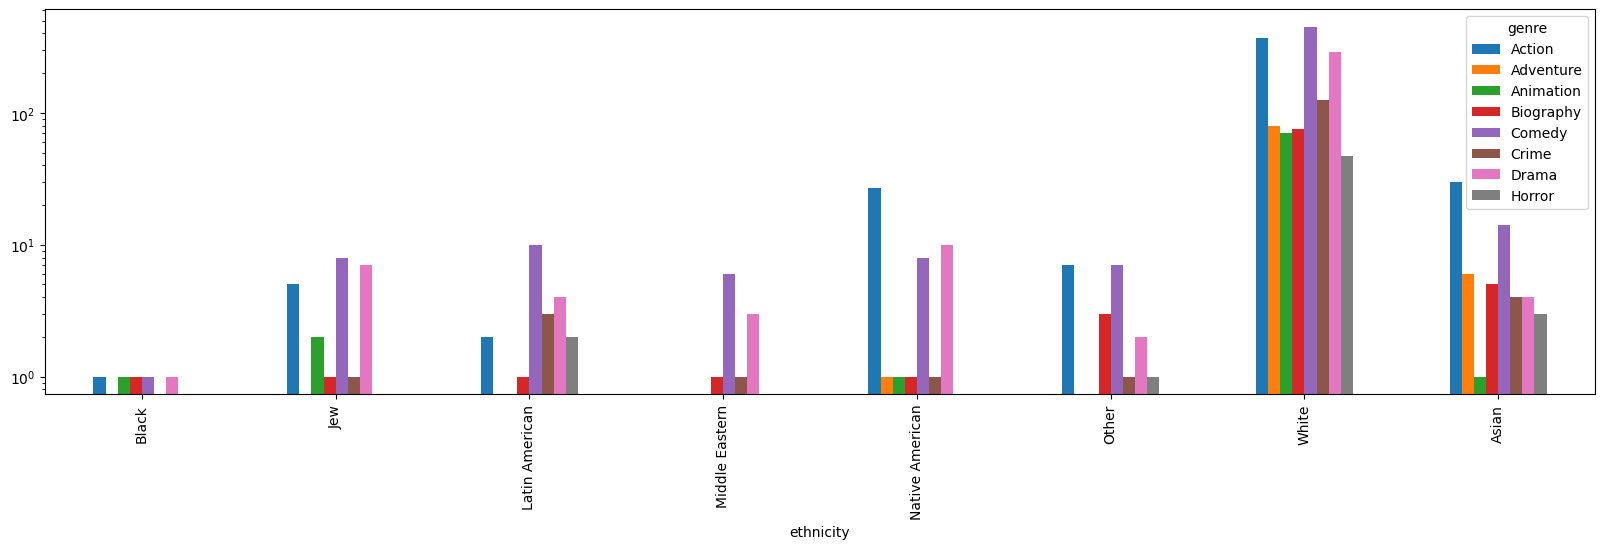

In [89]:
# let us first visualize this contingency table

ax = ethnicity_contingency.plot.bar(rot=90, figsize = (20,5))
ax.semilogy()

### 1.4.1 - Statistical analysis 

In [90]:
# now let us do more rebust tests with statistical methods
# get us look at the correlation between the gender of the lead role and the genre of a movie

genres = ethnicity_contingency.columns
# we will use Cramer's V method to calculate the correlation coefficient between the categorical variables
dataset_eth = np.array(ethnicity_contingency)

X2_eth = stats.chi2_contingency(dataset_eth, correction=False)[0]
N = np.sum(dataset_eth)
minimum_dimension = min(dataset_eth.shape)-1
  
# Calculate Cramer's V
result = np.sqrt((X2_eth/N) / minimum_dimension)
print(f"R = {result}")

R = 0.08365343176852458


In [91]:
# chi-squared test
dataset_eth = np.array(ethnicity_contingency)

stat_eth, p_value_eth, dof_eth, expected_freq_eth = stats.chi2_contingency(dataset_eth)
print(f"Test statistic = {stat_eth}, p-value = {p_value_eth}")

Test statistic = 83.86279341346795, p-value = 0.0014175513032746816


The p-value of the chi-square test is much smaller than 0.05, hence, we can reject the null hypothesis that there is no relationship between the ethnicity of the main actor and genre of the movie. Let us investigate further. We will compare the expected frequencies with the observed frequencies of the number of actors for the lead of a movie by genre per ethnicity.

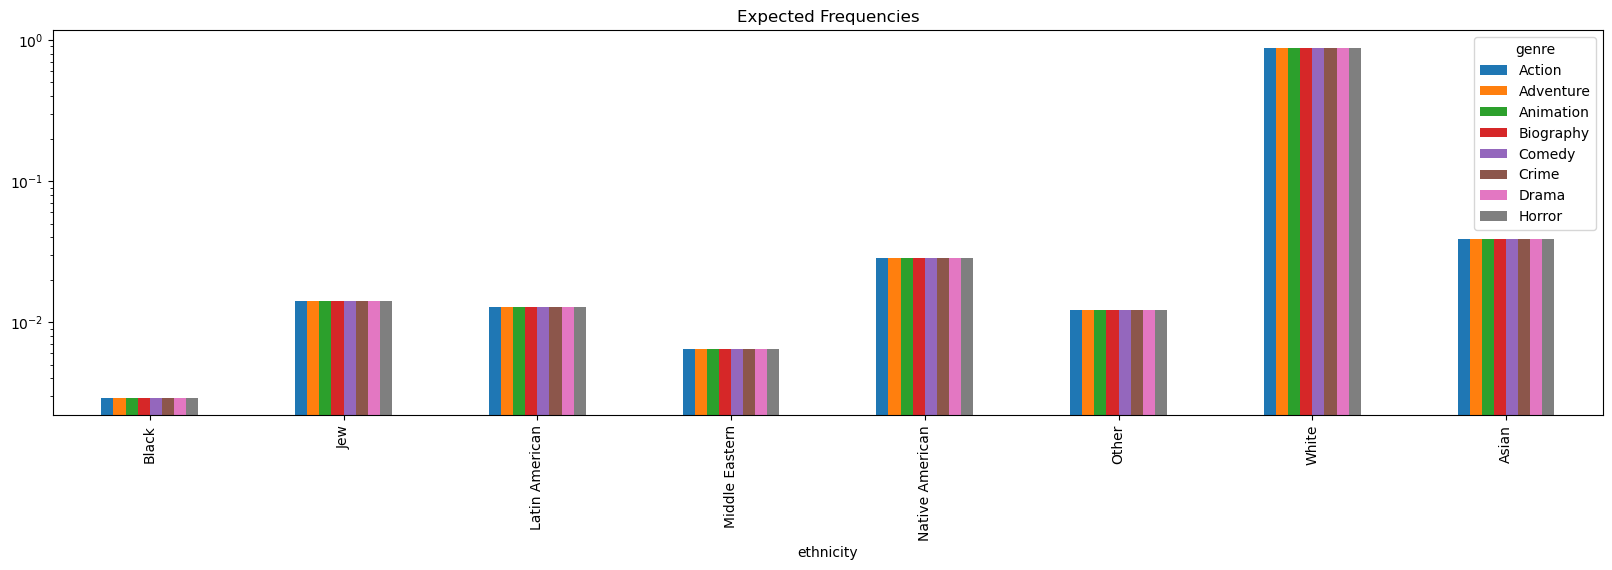

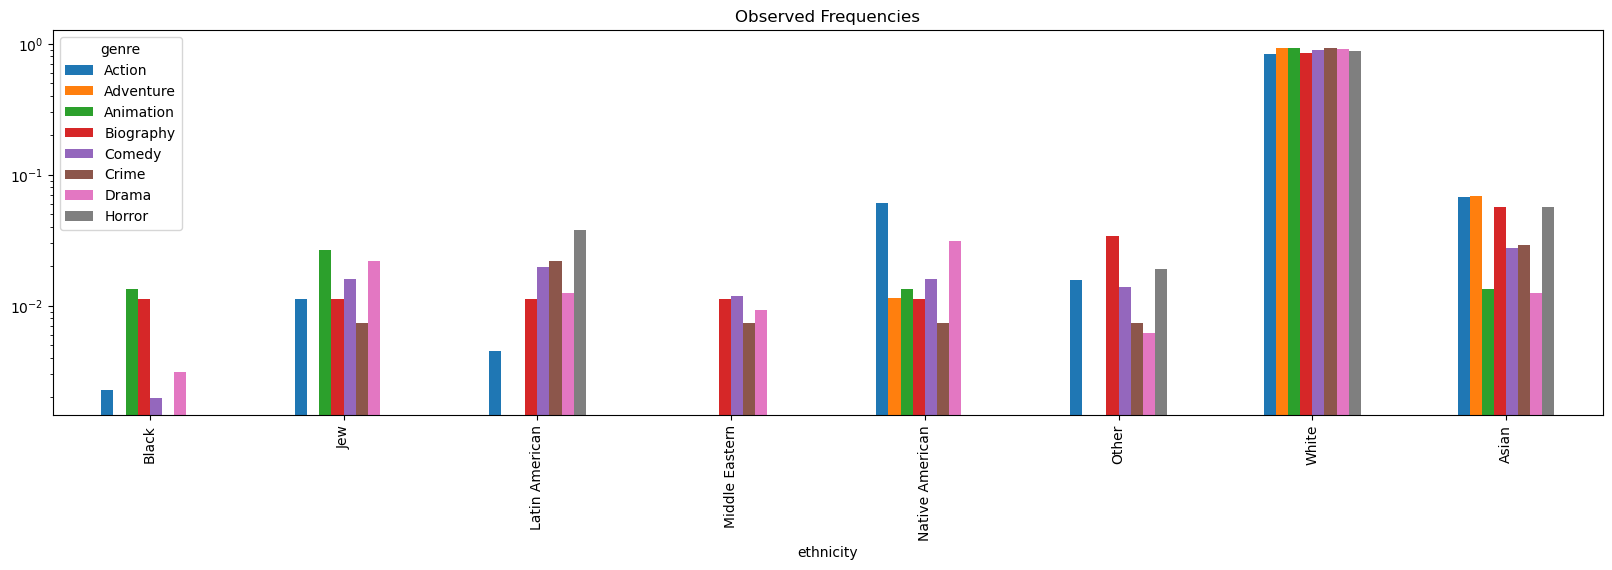

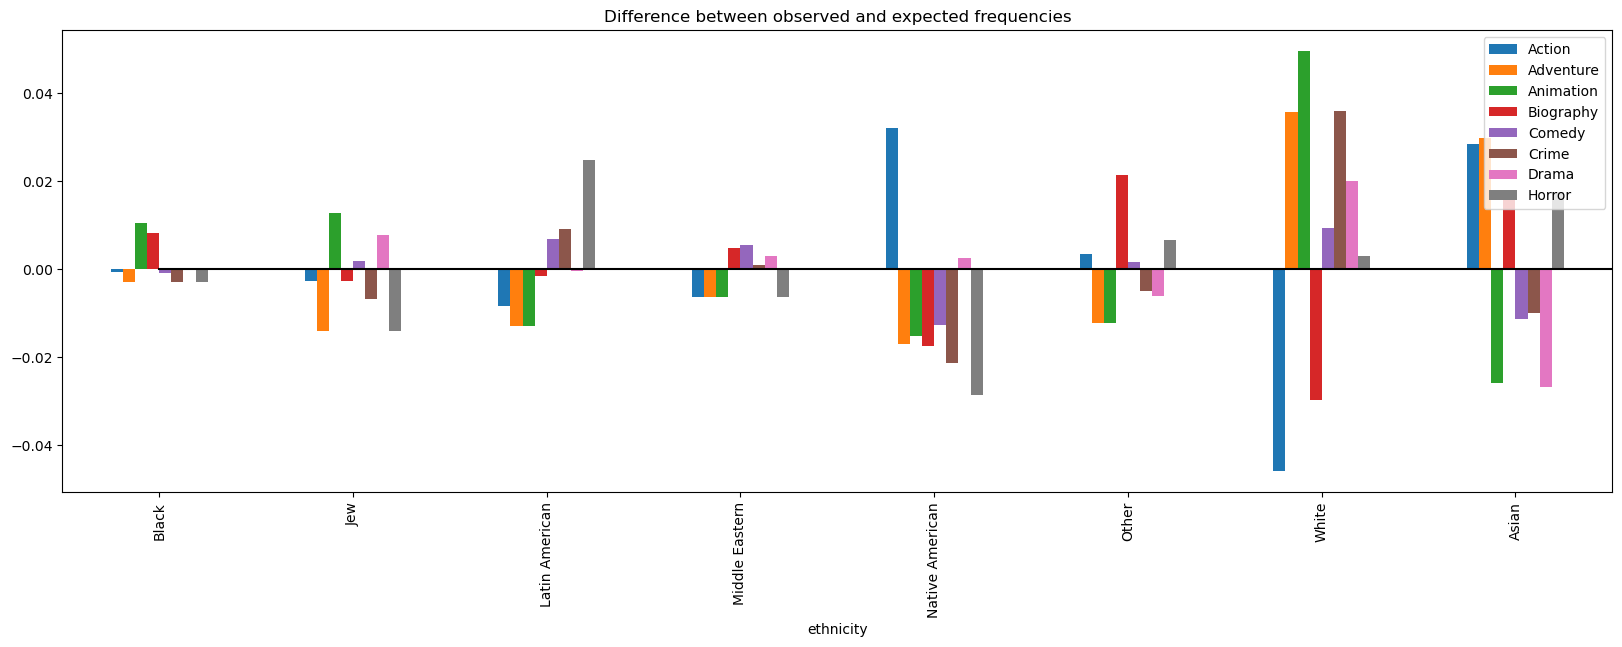

In [93]:
# converting expected frequencies into percentages
exp = pd.DataFrame(expected_freq_eth, index = ethnicity_contingency.index, columns = ethnicity_contingency.columns).apply(lambda x: x/sum(x))

# plotting the expected frequencies
ax1 = exp.plot.bar(rot=90, figsize = (20,5))
ax1.semilogy()
ax1.set_title('Expected Frequencies')

# converting observed frequencies into percentages
obs = pd.DataFrame(ethnicity_contingency).apply(lambda x: x/sum(x))

# plotting the observed frequencies
ax2= obs.plot.bar(rot=90, figsize = (20,5))
ax2.semilogy()
ax2.set_title('Observed Frequencies')

# getting difference between observed and expected frequencies in percentage
y = 0*X_axis
diff_eth = obs - exp

# plotting the difference
ax3= diff_eth.plot.bar(rot=90, figsize=(20,6))
ax3.plot(X_axis*2,y,'-k')
ax3.set_title('Difference between observed and expected frequencies')
ax3.legend(loc='upper right')

In [ ]:
# plot to be included on the project website

# plot first figure of expected values from the chi 2 test

fig1 = go.Figure()

for genre in range(len(exp.columns)):
    fig1.add_trace(go.Bar(x=exp.index, y = exp[exp.columns[genre]], name = exp.columns[genre]))
fig1.update_layout(barmode='group', xaxis_tickangle=-45, height = 400)
fig1.show()

# plot the second figure of observed values from the chi 2 test 

fig2 = go.Figure()
for genre in range(len(exp.columns)):
    fig2.add_trace(go.Bar(x=exp.index, y = obs[exp.columns[genre]], name = exp.columns[genre]))

fig2.update_layout(barmode='group', xaxis_tickangle=-45, height = 400)
fig2.show()

# plot the third figure showing the difference between the observed and expected values from chi 2 test 

fig3 = go.Figure()
for genre in range(len(exp.columns)):
    fig3.add_trace(go.Bar(x=exp.index, y = diff_eth[exp.columns[genre]], name = exp.columns[genre]))

fig3.update_layout(barmode='group', xaxis_tickangle=-45, height = 400)
fig3.show()


# 2 - Gender of the crew

## 2.1 - Data preprocessing
First, we need to process the data to get a dataframe that also contains the crew information.

In [95]:
# Merge ImDB crew and movie info
crew_title = pd.merge(crew_basic, movie_basics, on = 'tconst')
crew_title.rename(columns = {'primaryTitle': 'name'}, inplace = True)

# Duplicates in the crew_title dataset are deleted
# Still difference with number of unique names -> group by name by aggregating to a list the other info
crew_title = crew_title[['name', 'directors', 'writers']].drop_duplicates().groupby("name").progress_aggregate(lambda x: tuple(x))
movies_crew = movies_usa.merge(crew_title, on = 'name', how = 'inner')
movies_crew = movies_crew.dropna()

# Add gender to name dataset - 
# Use of the ImdB dataset to get info on director and not just use of the directors_sex because it hase multiple 
# directors per movies and contains info on writers as well. Also, it is a more reliable source
directors_sex.rename(columns = {'director': 'primaryName'}, inplace = True)
name_genders = pd.merge(name_basics, directors_sex[['primaryName', 'gender']], on = 'primaryName')

100%|██████████████████████████████| 4284769/4284769 [03:06<00:00, 22974.57it/s]


In [110]:
movies_crew.head(1)

,wiki_movieID,freebase_movieID,name,release,revenue,runtime,languages,countries,genres,directors,writers,dir_one_fem,dir_all_fem,wri_one_fem,wri_all_fem,year,crew_one_fem
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","(nm0000118, \N, nm3973010)","(nm0837917,nm0000118, \N, nm4270124,nm3973010,...",False,False,False,False,2001,False


In [111]:
# Print info possibly lost 
print(f'Total movies at beginning: {len(movies_db)}')
print(f'Total american movies: {len(movies_usa)}')
print(f'After merge with crew info: {len(movies_crew)}')
print(f'\nSamples lost to have info on crew/director: {len(movies_usa) - len(movies_crew)}')

Total movies at beginning: 81741
Total american movies: 34408
After merge with crew info: 6623

Samples lost to have info on crew/director: 27785


In [112]:
# Add the presence of at least one women or all women in crew to DataFrame
women = name_genders[name_genders['gender']=='female']['nconst']
movies_crew['dir_one_fem'] = movies_crew['directors'].progress_apply(
    lambda x: any(const_women == const_dir
                  for directors in x
                  for const_dir in directors.split(',')
                  for const_women in women
                 )) 

100%|██████████████████████████████████████| 6623/6623 [00:16<00:00, 402.11it/s]


In [113]:
movies_crew['dir_all_fem'] = movies_crew['directors'].progress_apply(
    lambda x: all(const_women == const_dir
                  for directors in x
                  for const_dir in directors.split(',')
                  for const_women in women
                 )) 

100%|███████████████████████████████████| 6623/6623 [00:00<00:00, 227507.35it/s]


In [114]:
movies_crew['wri_one_fem'] = movies_crew['writers'].progress_apply(
    lambda x: any(const_women == const_wri
                  for writers in x
                  for const_wri in writers.split(',')
                  for const_women in women
                 )) 

100%|██████████████████████████████████████| 6623/6623 [00:27<00:00, 241.66it/s]


In [115]:
movies_crew['wri_all_fem'] = movies_crew['writers'].progress_apply(
    lambda x: all(const_women == const_wri
                  for writers in x
                  for const_wri in writers.split(',')
                  for const_women in women
                 )) 

100%|███████████████████████████████████| 6623/6623 [00:00<00:00, 222056.91it/s]


In [116]:
movies_crew.head(1)

,wiki_movieID,freebase_movieID,name,release,revenue,runtime,languages,countries,genres,directors,writers,dir_one_fem,dir_all_fem,wri_one_fem,wri_all_fem,year,crew_one_fem
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","(nm0000118, \N, nm3973010)","(nm0837917,nm0000118, \N, nm4270124,nm3973010,...",False,False,False,False,2001,False


## 2.2 -  Does the proportion of movies with women in the crew change with time ?

### 2.2.1 - Yearly means

In [117]:
# Extract the year out of the date 
movies_crew['year'] = pd.to_datetime(movies_crew['release']).apply(lambda x: x.year)
movies_crew = movies_crew.dropna()

In [118]:
# Build specific DataFrames
# For this part, wa refers to at least one woman, w to all women, m to all men
# In terms of the directors
movies_dir_wa = movies_crew[movies_crew['dir_one_fem']==True]
movies_dir_w = movies_crew[movies_crew['dir_all_fem']==True]
movies_dir_m = movies_crew[movies_crew['dir_one_fem']==False]
# In terms of the writers
movies_wri_wa = movies_crew[movies_crew['wri_one_fem']==True]
movies_wri_w = movies_crew[movies_crew['wri_all_fem']==True]
movies_wri_m = movies_crew[movies_crew['wri_one_fem']==False]
# In terms of whole crew 
movies_crew['crew_one_fem'] = movies_crew['wri_one_fem'].apply(lambda x: int(x)) + movies_crew['dir_one_fem'].apply(lambda x: int(x)) > 0
movies_wa = pd.concat([ movies_crew[movies_crew['wri_one_fem']==True] , movies_crew[movies_crew['dir_one_fem']==True]])
movies_w = movies_crew[movies_crew['wri_all_fem']==True][movies_crew['dir_all_fem']==True]
movies_m = movies_crew[movies_crew['wri_one_fem']==False][movies_crew['dir_one_fem']==False]

/var/folders/hx/8nn0qpt93j907_9t2ty10thh0000gn/T/ipykernel_54289/22750684.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/hx/8nn0qpt93j907_9t2ty10thh0000gn/T/ipykernel_54289/22750684.py:15: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [119]:
tot = len(movies_crew)
# Check proportions of women directors
print('Number of movies directed by all women: ' + f"{len(movies_dir_w)}" + " == " + "{:.2%}".format(len(movies_dir_w) / tot) + " of total movies in dataset")
print('Number of movies directed by at least one woman: ' + f"{len(movies_dir_wa)}" + " == " + "{:.2%}".format(len(movies_dir_wa) / tot) + " of total movies in dataset")
print('Number of movies directed by all men: ' + f"{len(movies_dir_m)}" + " == " + "{:.2%}".format(len(movies_dir_m) / tot) +  " of total movies in dataset")

# Check proportions of women writters
print('\nNumber of movies written by all women: ' + f"{len(movies_wri_w)}" + " == " + "{:.2%}".format(len(movies_wri_w) / tot) + " of total movies in dataset")
print('Number of movies written by at least one woman: ' + f"{len(movies_wri_wa)}" + " == " + "{:.2%}".format(len(movies_wri_wa) / tot) + " of total movies in dataset")
print('Number of movies written by all men: ' + f"{len(movies_wri_m)}" + " == " + "{:.2%}".format(len(movies_wri_m) / tot) + " of total movies in dataset")

# Check proportions of women crew members
print('\nNumber of movies written and directed by women: ' + f"{len(movies_w)}" + " == " + "{:.2%}".format(len(movies_w) / tot) + " of total movies in dataset")
print('Number of movies written and directed by at least one woman: ' + f"{len(movies_wa)}" + " == " + "{:.2%}".format(len(movies_wa) / tot) + " of total movies in dataset")
print('Number of movies written and directed by all men: ' + f"{len(movies_m)}" + " == " + "{:.2%}".format(len(movies_m) / tot) + " of total movies in dataset")

Number of movies directed by all women: 0 == 0.00% of total movies in dataset
Number of movies directed by at least one woman: 396 == 5.98% of total movies in dataset
Number of movies directed by all men: 6227 == 94.02% of total movies in dataset

Number of movies written by all women: 0 == 0.00% of total movies in dataset
Number of movies written by at least one woman: 278 == 4.20% of total movies in dataset
Number of movies written by all men: 6345 == 95.80% of total movies in dataset

Number of movies written and directed by women: 0 == 0.00% of total movies in dataset
Number of movies written and directed by at least one woman: 674 == 10.18% of total movies in dataset
Number of movies written and directed by all men: 6108 == 92.22% of total movies in dataset


### 2.2.2 - Plot the yearly evolution

In [120]:
# yearly releases of movies 
tot = movies_crew.groupby('year').aggregate('count')['wiki_movieID']
# Yearly releases of movies directed by men/women 
plot_w_d = movies_crew.groupby('year').aggregate(sum)['dir_all_fem'] 
plot_wa_d = movies_crew.groupby('year').aggregate(sum)['dir_one_fem']  
# Yearly releases of movies written by men/women 
plot_w_w = movies_crew.groupby('year').aggregate(sum)['wri_all_fem']
plot_wa_w = movies_crew.groupby('year').aggregate(sum)['wri_one_fem']  
# Yearly releases of movies containing at least one woman in the crew
plot_wa = movies_crew.groupby('year').aggregate(sum)['crew_one_fem']  
plot_m = tot - plot_wa

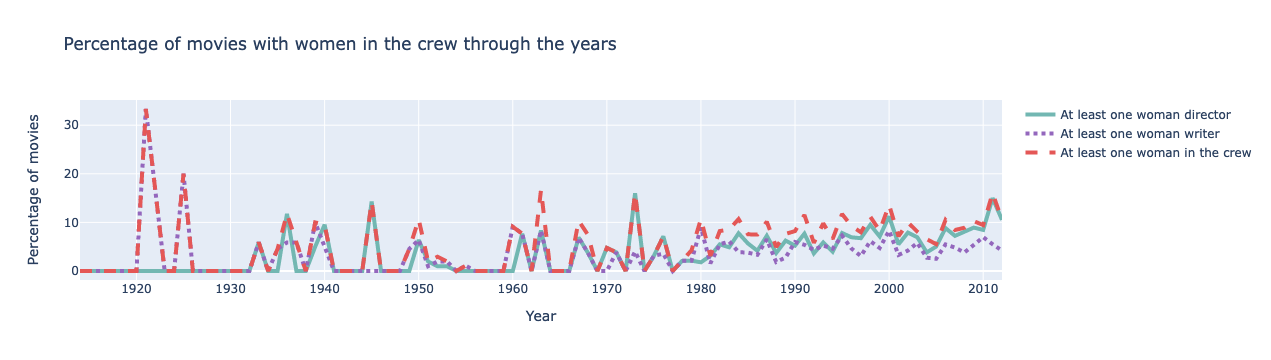

In [121]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_wa_d.index, y=plot_wa_d/tot*100, name='At least one woman director',
                         line=dict(color='#72B7B2', width=4)))

fig.add_trace(go.Scatter(x=plot_wa_w.index, y=plot_wa_w/tot*100, name='At least one woman writer',
                         line=dict(color='#9467BD', width=4, dash='dot')))


fig.add_trace(go.Scatter(x=plot_wa.index, y=plot_wa/tot*100, name='At least one woman in the crew',
                         line=dict(color='#E45756', width=4, dash='dash')))

# Edit the layout
fig.update_layout(title='Percentage of movies with women in the crew through the years',
                   xaxis_title='Year',
                   yaxis_title='Percentage of movies')

fig.show()

### 2.2.3 -  Statstical tests
To look at the impact of the gender of the crew on the number of movies we will use the Mann Whitney U test. The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y. It is often used as a test of difference in location between distributions.

In [122]:
result = stats.mannwhitneyu(plot_wa, plot_m)
print(result)
print('The p-value is under 0.05 so there we can significantly reject the null hypothesis. \nThe two distributions are statistically different.')

MannwhitneyuResult(statistic=1016.5, pvalue=5.688230337318429e-20)
The p-value is under 0.05 so there we can significantly reject the null hypothesis. 
The two distributions are statistically different.


Next, we want to check if the proportion of women in the crew changes with time. This means that we need to test if the time-series is stationnary, meaning that the mean and variance are constant with time and that there is a constant covariance between periods of identical distance. For this, we use an ADF-Test. The null hypothesis is that the time-serie is not stationary. Hence, this test will not confirm that the time-series is not stationary, it will just tell us if we can reject this hypothesis.   

In [ ]:
result = sts.adfuller(plot_wa)
print(result)
print(f'p-value = {0.995} > 0.05, we cannot reject the hypothesis that this time-series is stationary')

In [ ]:
# Let us now try with a subset of the dataset, namely the movies that were released after 1985
result = sts.adfuller(plot_wa[plot_wa.index>1985])
print(result)
print(f'p-value = {0.0002} < 0.05, we canreject the hypothesis that this time-series is stationary')
print('There has been no evolution of the proportion of woman in the crew since 1985')

# 3 - Revenue comparisons 

Finally, we will answer these questions: 

Is there a noticeable difference in revenue for movies that portray some particular genre? Is there a noticeable difference in revenue for movies created by women ?

We will not look at the statistical difference for ethnicities as there are not enough minorities samples. However, the impact of main character being white or not will be measured in part 4.3. 

To look at the impact of the gender on the revenue we will use the Mann Whitney U test. The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y. It is often used as a test of difference in location between distributions.

## 3.1 - In terms of the gender of the main actor

### 3.1.1 - Naïve approach

In [ ]:
# dataframe to work on for this part of the analysis 
gender = movies_usa_gender.copy()
print(f"We have {len(female)} movies starring women and {len(male)} movies starring men.")

In [ ]:
female.revenue.describe()

In [ ]:
male.revenue.describe()

In [ ]:
# let us look at movie revenue differences between male and female movie stars

female = gender[gender['gender']=='F']
male = gender[gender['gender']=='M']

plt.figure(figsize=(15,5))
ax = sns.histplot(female['revenue'], kde=True, stat='density', color='purple', label='female')
ax = sns.histplot(male['revenue'], kde=True, stat='density', color='blue', label='male')
ax.set(title='Movie Revenue distribution for male and female stars',xlabel='Revenue', ylabel='Revenue density')
plt.legend()
plt.semilogx()
plt.show()

In [ ]:
# revenue plot to be included on the website page
import plotly.express as px

fig = px.histogram(movies_usa_gender, x="revenue", color="gender", log_y = True, marginal="box",
                  title = "Movie Revenue distribution by gender of protagonist")
fig.show()

The mean revenue of movies starring women is about 5.8 million dollars and the mean revenue of movies starring men is about 8.5 million dollars. With a naive analysis, it looks like movies with male protagonists earn more revenue.

Let us investigate wether or not this difference is significant with a statistical test. These distributions are not normally distributed, so we cannot use a t-test which is a parametric statistical test. We can use a non-parametric equivalent which is the Mann–Whitney U test. The variable we are analysing (revenue) is continuous, revenue observations from male and female movie groups are independent of each other, and the variable of intrest is skewed.

The null hypothesis (Ho) in conducting the Mann–Whitney U test is that the revenue for movies with male versus female protagonists are equal. With the alternative hypothesis being that they are different. Our significance level for this test (alpha) is chosen to be 0.05.

In [ ]:
# conducting Wilcoxon Signed-rank test on revenue (outcome) by gender (predictor)

revenue_F = list(female['gross'])
revenue_M = list(male['gross'])

result = stats.mannwhitneyu(revenue_F, revenue_M, nan_policy='omit')
print(result)

print(f"Movies portraying men have a {round(male['gross'].mean()/female['gross'].mean(),2)*100}% higher budget on average.")

The p-value is much smaller than 0.05, hence, we can reject the hull hypothesis that there is no difference between the movie revenue for movies portraying male versus female actors. Movies portraying men each significantly more than movies portraying women. 

However, we already know that there is a correlation between budget and revenue for movies. Some movie genres could also be more popular than others, the revenue of a movie can also depend on it's score... All these variables could be confounders that influence the revenue of a movie as well as wether or not the protagonist is a male or female. So let us check if this difference in revenue isn't because of a lower spending budget, or some other factor to begin with.

### 3.1.2 - Robust analysis with propensity score matching 

Our first job is to look at wether or not there could be some confounding factors affecting the revenue of the movie and the gender of the movie star. These could be the genre of the movie, the score of the movie, the budget of the movie or the year of release of the movie. We will investigate there features one by one.

In [ ]:
# creating data frame for further analysis
gender = movies_usa_gender.copy()
gender.head(1)

In [ ]:
# let us look at the movie score distribution by gender of main character
gender.boxplot(by='gender', column='score', figsize = [5, 5], grid=True)
plt.show()
print("Movies that portray men have a higher scores on average.")

In [ ]:
# plot to be used on the project website
fig = px.box(gender, x="gender", y="score", color = "gender", title = "Movie Score by gender of protagonist")
fig.show()

In [ ]:
# let is look at the release year of movies as a function of the gender of the movie star
gender.boxplot(by='gender', column='year', figsize = [5, 5], grid=True)
plt.show()
print("More recently released movies are more likely to portray women than older movies.")

In [ ]:
# plot to be used on the project website
fig = px.box(gender, x="gender", y="year", color = "gender", title = "Movie Release year by gender of protagonist")
fig.show()

In [ ]:
# let us look at movie budget differences between male and female movie stars
female = gender[gender['gender']=='F']
male = gender[gender['gender']=='M']
ax = sns.histplot(female['budget'], kde=True, stat='density', color='purple', label='female')
ax = sns.histplot(male['budget'], kde=True, stat='density', color='blue', label='male')
ax.set(title='Movie Budget distribution for male and female protagonists',xlabel='Budget', ylabel='Budget density')
plt.legend()
plt.show()

In [ ]:
# revenue plot to be included on the website page
fig = px.histogram(movies_usa_gender, x="budget", color="gender", log_y = True, marginal="box",
                  title = "Movie Budget distribution by gender of protagonist")
fig.show()

Women seem to star in movies that have a smaller budget to begin with, which could in turn impact the revenue of the movie. This can also be a confounding factor in our analysis. Let us investigate if this difference is significant. These distributions are not normally distributed, so we cannot use a t-test which is a parametric statistical test. We can use a non-parametric equivalent which is the Mann–Whitney U test. The variable we are analysing (revenue) is continuous, revenue observations from male and female movie groups are independent of each other, and the variable of intrest is skewed.

In [ ]:
# create lists of budgets of female and male movies 
budget_F = list(female['budget'])
budget_M = list(male['budget'])

# run Mann Whitney U test
result = stats.mannwhitneyu(budget_F, budget_M, nan_policy='omit')
print(result)
print(f"Movies portraying men have a {round(male['budget'].mean()/female['budget'].mean(),2)*100}% higher budget on average.")

The p-value for this test is much smaller than 0.05. Hence, we reject the hull hypothesis that there is no significant difference in budget for movies who portray female actors versus male actors. 

In [ ]:
gender_contingency = pd.crosstab(movies_usa_gender['gender'],
                            movies_usa_gender['genre'],
                                margins = False)
X = movies_usa_gender['genre'].unique()
Y_female = gender_contingency.loc['F',:]
Y_male = gender_contingency.loc['M',:]
X_axis = np.arange(len(X))

plt.figure(figsize=(15,4))
plt.bar(X_axis-0.2, Y_female, 0.4, label = 'Female', color = 'orchid')
plt.bar(X_axis+0.2, Y_male, 0.4, label = 'Male', color = 'royalblue')

plt.xticks(X_axis, X, rotation = 90)
plt.xlabel("Genres")
plt.ylabel("Number of lead roles")
plt.title("Lead role gender by movie genre")
plt.legend()
plt.show()

In [ ]:
# plot to be used on website page of the study 
# create dataframe with number of movies per movie genre for Female and Male
genre_df = gender.groupby(by=["genre","gender"]).size().reset_index(name="number of movies")
genre_df_F = genre_df[genre_df['gender']=='F']
genre_df_M = genre_df[genre_df['gender']=='M']

# x axis 
genres = gender['genre'].unique()

# plot
fig = go.Figure()
fig.add_trace(go.Bar(x=genres,y=genre_df_F['number of movies'],name='Female',marker_color='indianred'))
fig.add_trace(go.Bar(x=genres,y=genre_df_M['number of movies'],name='Male',marker_color='lightsalmon'))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

From analysis done in the previous part, we know that women are more likely to star in Horror, Drama and Comedy movies, but less likely to star in Action, Crime, or Animation movies. Hence, the genre of the movie could also be a confounding factor in the movie revenue (outcome).

In [ ]:
# propensity score matching 
# our features are: genre, rating, year, budget

# make dummies for movie genres
gender = pd.get_dummies(gender, columns=['genre'])
gender['gender'] = gender['gender'].apply(lambda x: 1 if x=='F' else 0)
gender.head(1)
# standardize continuous features
gender['score'] = (gender['score'] - gender['score'].mean())/gender['score'].std()
gender['year'] = (gender['year'] - gender['year'].mean())/gender['year'].std()
gender['budget'] = (gender['budget'] - gender['budget'].mean())/gender['score'].std()
gender['runtime'] = (gender['runtime'] - gender['runtime'].mean())/gender['score'].std()

# drop movies without any budget information
gender = gender.dropna(subset=['budget'])

gender.head(1)

In [ ]:
# run logistic regression to predict propensity score
# rename sci-fi column to avoid error in logistic regression
gender.rename(columns = {'genre_Sci-Fi':'genre_SciFi'}, inplace = True)


mod = smf.logit(formula='gender ~  score + year + budget + genre_Action  + genre_Adventure + genre_Animation + \
        + genre_Biography + genre_Comedy + genre_Crime + genre_Drama +  genre_Fantasy \
        + genre_Horror + genre_Mystery', data=gender)

res = mod.fit()

# Extract the estimated propensity scores
gender['Propensity_score'] = res.predict()

print(res.summary())

In [ ]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [ ]:
# Separate the treatment and control groups
female = gender[gender['gender'] == 1]
male = gender[gender['gender'] == 0]

In [ ]:
# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for male_id, male_row in male.iterrows():
    for female_id, female_row in female.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(male_row['Propensity_score'],
                                    female_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(male_id, female_id, similarity)])
# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_df_1 = gender.loc[matched]
balanced_df_1.head()
balanced_df_1.to_csv(path + 'balanced_df_1.csv')
print('The actual matching does not have to be run each time as it is very long, the dataframe is saved and loaded')

In [ ]:
balanced_df_1 = pd.read_csv(path + "balanced_df_1.csv")
print(len(balanced_df_1))

In [ ]:
female_balanced = balanced_df_1.loc[balanced_df_1['gender'] == 1] #People that attained the program
male_balanced = balanced_df_1.loc[balanced_df_1['gender'] == 0] #People that didn't attain the program

In [ ]:
female_balanced.revenue.describe()

In [ ]:
male_balanced.revenue.describe()

In [ ]:
# let us look at movie revenue differences between male and female movie stars

plt.figure(figsize=(15,5))
ax = sns.histplot(female_balanced['revenue'], kde=True, stat='density', color='purple', label='female')
ax = sns.histplot(male_balanced['revenue'], kde=True, stat='density', color='blue', label='male')
ax.set(title='Movie Revenue distribution for male and female stars',xlabel='Revenue', ylabel='Revenue density')
plt.legend()
plt.semilogx()
plt.show()

In [ ]:
# balanced revenue plot to be included on the website page

# convert '1' into 'F' and '0' into 'M' for the gender column for plotting
balanced_df_1['gender'] = balanced_df_1['gender'].apply(lambda x: 'F' if x==1 else 'M')

# plot
fig = px.histogram(balanced_df_1, x="revenue", color="gender", log_y = True, marginal="box",
                  title = "Movie Revenue distribution by gender of protagonist after balancing")
fig.show()

The distribution clearly looks different than before, movies starring women gross higher than women starring men according to this histogram. Let us perform a statistical significance test again to check wether or not this different is statistically significant or pure chance.


In [ ]:
# using the Mann Whitney U test again on revenue
revenue_F = list(female_balanced['revenue'])
revenue_M = list(male_balanced['revenue'])

result = stats.mannwhitneyu(revenue_F, revenue_M, nan_policy='omit')
print(result)

The p-value is still lower than 0.05, hence we reject the null hypothesis that the average difference in revenue for movies starring males and females is equal. There is still a statistically significant difference, however, with propensity score matching, it seems that movies starring women gross higher at the box office than movies starring men.

In [ ]:
print(f"Movies portraying women have earned on average {round(female_balanced['revenue'].mean()/1000000,2)} milion USD.")
print(f"Movies portraying men have earned on average {round(male_balanced['revenue'].mean()/1000000,2)} milion USD.")
print(f"Hence, movies portraying women earn {round(female_balanced['revenue'].mean()/male_balanced['revenue'].mean()*100,2)}% more than movies portraying Men.")

## 3.2 - In terms of the gender of the crew

### 3.2.1 - Naïve approach

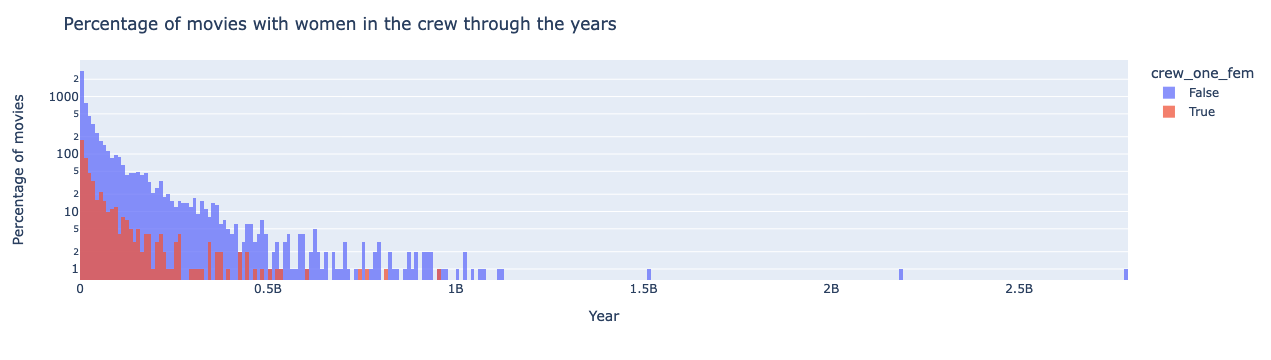

In [124]:
# Plot revenue distribution comparison between gender of the crew
fig = px.histogram(movies_crew, x="revenue", color="crew_one_fem", log_y=True)

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)

# Edit the layout
fig.update_layout(title='Percentage of movies with women in the crew through the years',
                   xaxis_title='Year',
                   yaxis_title='Percentage of movies')

fig.show()

### 3.2.2 - Matching revenue with budget

In [125]:
movies_budget = pd.merge(movies_crew, mainchar_budget[['name', 'budget', 'genre']], on = 'name').dropna()

In [126]:
# Info lost 
print(f'Total movies at beginning: {len(movies_crew)}')
print(f'After merge with budget info: {len(movies_budget)}')
print(f'\nSamples lost to have info on budget: {len(movies_crew) - len(movies_budget)}')

Total movies at beginning: 6623
After merge with budget info: 3601

Samples lost to have info on budget: 3022


In [127]:
# Correlation between budget and revenue
result = stats.pearsonr(movies_budget['revenue'], movies_budget['budget'])
print(result)
print('p-vaue is below 0.05. \nThere is a significant positive correlation between the revenue and the budget. \nMatching on the budget to study the revenue makes sense.')

(0.6269933725690559, 0.0)
p-vaue is below 0.05. 
There is a significant positive correlation between the revenue and the budget. 
Matching on the budget to study the revenue makes sense.


In [128]:
# Preprocess movie_budget df
# standardize continuous features
movies_budget['year'] = (movies_budget['year'] - movies_budget['year'].mean())/movies_budget['year'].std()
movies_budget['budget'] = (movies_budget['budget'] - movies_budget['budget'].mean())/movies_budget['budget'].std()
# To numeric to make the regression work  
movies_budget['year'] = pd.to_numeric(movies_budget['year'])
movies_budget['budget'] = pd.to_numeric(movies_budget['budget'])
movies_budget['crew_one_fem'] = pd.to_numeric(movies_budget['crew_one_fem'].apply(lambda x: int(x)))
print(movies_budget.columns)

Index(['wiki_movieID', 'freebase_movieID', 'name', 'release', 'revenue',
       'runtime', 'languages', 'countries', 'genres', 'directors', 'writers',
       'dir_one_fem', 'dir_all_fem', 'wri_one_fem', 'wri_all_fem', 'year',
       'crew_one_fem', 'budget'],
      dtype='object')


In [129]:
# Regression 
mod = smf.logit(formula='crew_one_fem ~ year + budget', data=movies_budget)
res = mod.fit()
# Extract the estimated propensity scores
match_pro['Propensity_score'] = res.predict()
print(res.summary())

In [ ]:
# Similarity function 
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [ ]:
# Separate in the two groups to be matched (at least one women, only men)
wa = match_pro[match_pro['crew_one_fem'] == 1]
m = match_pro[match_pro['crew_one_fem'] == 0]

In [ ]:
"""# Create an empty undirected graph
G = nx.Graph()
# Loop through all the pairs of instances
for m_id, m_row in m.iterrows():
    for wa_id, wa_row in wa.iterrows():
        if wa_row['genre'] == m_row['genre']:
            # Calculate the similarity 
            similarity = get_similarity(m_row['Propensity_score'],
                                        wa_row['Propensity_score'])
            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(m_id, wa_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)
matched_pro = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
macthed_df2 = match_pro.loc[matched_pro]
macthed_df2.to_csv(path + 'matched_df2.csv')"""
print('The actual matching does not have to be run each time as it is very long, the dataframe is saved and loaded')

In [ ]:
matched_df = pd.read_csv(path + "matched_df2.csv")
print(len(matched_df))

### 3.2.3 - Plots

In [ ]:
# Plot revenue distribution comparison between gender of the crew
fig = px.histogram(matched_df, x="revenue", color="crew_one_fem", log_y=True)

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)

# Edit the layout
fig.update_layout(title='Percentage of movies with women in the crew through the years',
                   xaxis_title='Year',
                   yaxis_title='Percentage of movies')
fig.show()

### 3.2.4 - Statistical tests

In [ ]:
# Correlation between gender of crew and budget
revenue_F = matched_df[matched_df['crew_one_fem']==1]['budget']
revenue_M = matched_df[matched_df['crew_one_fem']==0]['budget']
result = stats.mannwhitneyu(revenue_F, revenue_M)
print('AFTER MATCHING')
print(result)
print('p-value bigger than 0.05 so we cannot reject the null hypthesis. \nThe distribution of the budget is not different if the crew contains a woman or not.') 

# Results before matching
revenue_F = movies_budget[movies_budget['crew_one_fem']==1]['budget']
revenue_M = movies_budget[movies_budget['crew_one_fem']==0]['budget']
result = stats.mannwhitneyu(revenue_F, revenue_M)
print('\nBEFORE MATCHING')
print(result)

In [ ]:
# Correlation between gender of crew and revenue
revenue_F = matched_df[matched_df['crew_one_fem']==1]['revenue']
revenue_M = matched_df[matched_df['crew_one_fem']==0]['revenue']
result = stats.mannwhitneyu(revenue_F, revenue_M)
print('AFTER MATCHING')
print(result)
print('p-value smaller than 0.05 so we can reject the null hypthesis. \nThe distribution of the revenue is different if the crew contains a woman or not.') 

# Results before matching
revenue_F = movies_budget[movies_budget['crew_one_fem']==1]['revenue']
revenue_M = movies_budget[movies_budget['crew_one_fem']==0]['revenue']
result = stats.mannwhitneyu(revenue_F, revenue_M)
print('\nBEFORE MATCHING')
print(result)

## 3.3 - OLS to predict the revenue

In [ ]:
print(matched_df.columns)
print(mainchar_budget.columns)
print(movies_usa_ethnicity.columns)

In [ ]:
ols_df = pd.merge(mainchar_budget[['name', 'genre']], matched_df, on='name')
ols_df = pd.merge(movies_usa_ethnicity[['name', 'ethnicity']], ols_df, on='name')

genres = ols_df['genre'].unique()
genres_dummies = pd.get_dummies(ols_df['genre'])

ethinicity_dummies = pd.get_dummies(ols_df['ethnicity'])

ols_df = pd.concat([ols_df, genres_dummies, ethinicity_dummies['White']], axis = 1)
ols_df.head(1)

In [ ]:
print(ols_df['genre'].unique())

In [ ]:
# Perform an ordinary least squares linear regression
test_df = ols_df.copy()
test_df['revenue'] = pd.to_numeric(test_df['revenue'])
test_df['budget'] = pd.to_numeric(test_df['budget'])
test_df['year'] = pd.to_numeric(test_df['year'])
test_df['Action'] = pd.to_numeric(test_df['Action'])

results = smf.ols('revenue ~ budget + crew_one_fem + year + White + Action + Adventure + Drama + Animation + Comedy + Horror', data=test_df).fit()
results.summary()

# 4 - NLP of summaries

In [131]:
!pip install lxml

In [135]:
movies_usa

,wiki_movieID,freebase_movieID,name,release,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an..."
...,...,...,...,...,...,...,...,...,...
81725,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana..."
81726,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
81727,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/05p553"": ""Comedy film"", ""/m/02l7c8"": ""Rom..."
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"


In [137]:
# Extract american movies

#Get all wiki_ids with processed NLP
wikid_nlp=[int(os.path.basename(x)[0:-7]) for x in glob.glob('../corenlp_plot_summaries/*.xml.gz')]

#Get wikid_id intersection of american movies and movies with NLP processed plot
wikid_usa=set(movies_usa['wiki_movieID'].values) & set(wikid_nlp)

#Remove movies without plots and not american
wikid_remove=set(wikid_nlp)-wikid_usa
_=[os.remove('../corenlp_plot_summaries/'+str(wiki)+'.xml.gz') for wiki in wikid_remove]

len_nlp=len(os.listdir('../corenlp_plot_summaries/'))
print(f'{len_nlp} plots will be processed')

17777 plots will be processed


The next cell takes at least 5 hours to run, the output is a dataframe of all characters with word lemmas related to them.
#### You can skip this cell, the output can directly be load from a csv called descriptions

In [2]:
"""#This will be the fataframe containing all characters descriptions
descriptions=pd.DataFrame(columns=['wiki_id', 'character', 'mentioning', 
                                   'sentence_position', 'word_position', 'descriptions'])
#Looping through all files in folder
for filename in tqdm(glob.glob('../corenlp_plot_summaries/*.xml.gz')):
        with gzip.open('../corenlp_plot_summaries/'+filename, 'r') as f:
            
            # Reading the data inside the xml file to a variable under the name data
            data = f.read()
            
            #Get wiki id by getting the basename and removing the extension
            wikid = os.path.basename(filename)[0:-7]
            
            # Passing the stored data inside the beautifulsoup parser
            soup = BeautifulSoup(data, "xml")
            
            #DataFrame of all coreferences of the movie     
            coreferences = pd.DataFrame(columns=['wiki_id', 'character', 'mentioning', 
                                   'sentence_position', 'word_position', 'descriptions'])

            #Find all entities with coreferences 
            entities = soup.find_all("coreference")
            entities = entities[1:]

            for entity in entities:
                #Find every time this entity is mentioned
                mentions = entity.find_all("mention")
                
                #Find the representative aka the original mention of entity
                rep = entity.find("mention", {'representative':True})
                
                #Get sentence and word position of this representative
                sent_pos = int(rep.sentence.text)
                word_pos = int(rep.head.text)
                
                #Search for the word using positions
                sent = soup.find('sentence', {'id':sent_pos})
                word = sent.find('token', {'id':word_pos})
                
                #If the word is a person (character) create a full name variable
                if word.NER.text == 'PERSON':
                    person = word
                    full_name = person.word.text
                else: #Else the representative is not a character
                    continue #skip this entity

                #Finding the words before (e.g Dr. Prof.) that are part of the full name
                word_before = person.previous_sibling.previous_sibling
            
                if word_before is not None:
                    
                    #Loop while the words before are compounds of the proper noun
                    while word_before.POS.text == 'NNP':
                        full_name = word_before.word.text+' ' +full_name
                        word_before = word_before.previous_sibling.previous_sibling
                        if word_before is None:
                            break

                #Finding the words after (last name)     
                word_after = person.next_sibling.next_sibling
                if word_after is not None:
                    
                    #Loop while the words after are compounds of the proper noun
                    while word_after.POS.text=='NNP':
                        full_name = full_name+ ' ' + word_after.word.text
                        word_after = word_after.next_sibling.next_sibling
                        if word_after is None:
                            break
                            
                
                #Loop through the other mentioning of the representative
                for mention in mentions:
                    
                    #Get sentence and word position of mention
                    sent_pos = int(mention.sentence.text)
                    word_pos = int(mention.head.text)
                    
                    #Retrieve the word
                    sent = soup.find('sentence', {'id':sent_pos})
                    word = sent.find('token', {'id':word_pos}).word.text
                    
                    #Create the tuple for this mention and append it to the coreferences dataframe
                    add_tuple = pd.DataFrame([[wikid, full_name, word,sent_pos,word_pos]], columns=['wiki_id', 'character', 'mentioning', 
                                                   'sentence_position', 'word_position'])

                    coreferences = pd.concat([coreferences, add_tuple])
    

            #Find all dependencies in the plot. Creates a list of dependencies
            #each element is a sentence
            deps = soup.find_all("collapsed-ccprocessed-dependencies")
            
            #Enumerate all the coreferences of the plot to find their dependencies
            for i, (char, sent_pos,token_pos) in enumerate(coreferences[['character', 'sentence_position', 'word_position']].values):   
                
                #List for character as dependent
                char_as_dep = set()
                #List for character as governor
                char_as_gov = set()
                
                #Get the right sentence
                sentence = deps[sent_pos-1]
                
                #With token position of the coreference, find its relationship with other words
                
                #As dependent first
                dependent = sentence.find_all('dependent', {'idx':token_pos})
                for dep in dependent:
                    relation = dep.parent
                    
                    #We search for the relation types of our interest
                    if relation['type'] == 'nsubj' or relation['type'] == 'appos' \
                            or relation['type'] == 'nsubjpass' :
                        #We could directly retrieve the word in this dependence section 
                        #but we rather have the lemmatized token
                        word_pos = relation.governor['idx']
                        sent = soup.find('sentence', {'id':sent_pos})
                        word = sent.find('token', {'id':int(word_pos)})
                        char_as_dep.update({word.lemma.text})
    
                #As governor
                governor = sentence.find_all('governor', {'idx':token_pos})
                for gov in governor:
                    relation = gov.parent
                    if relation['type'] == 'rcmod' or relation['type'] == 'amod':
                        word_pos = relation.dependent['idx']
                        sent = soup.find('sentence', {'id':sent_pos})
                        word = sent.find('token', {'id':int(word_pos)})
                        char_as_gov.update({word.lemma.text})
                
                #Add the descriptions to the coreferences tuple
                char_as_dep.update(char_as_gov)
                coreferences['descriptions'].iloc[i] = char_as_dep
            
            #Append the coreferences of the movie to the global DataFrame
            descriptions=pd.concat([descriptions, coreferences])
            
            
#Some duplicates happen. We drop them but need to stringify because sets are not hashable.
descriptions = descriptions[~descriptions.astype(str).duplicated(keep='first')]

descriptions = descriptions.groupby(['wiki_id', 'character'])['descriptions'].apply(list).reset_index(name='descriptions')

descriptions['descriptions']=descriptions['descriptions'].apply(lambda x: [val for sublist in x for val in sublist])

#descriptions.to_csv('descriptions.csv')"""
;

''

Load the descriptions data

In [332]:
descriptions=pd.read_csv(path+"descriptions.csv")
descriptions.drop(['Unnamed: 0'], axis=1, inplace=True)
descriptions.drop(['Unnamed: 0.1'], axis=1, inplace=True)
descriptions.rename(columns={"character": "char_name", 'wiki_id': 'wiki_movieID'}, inplace=True)

#We unstringify the lists
descriptions['descriptions']=descriptions['descriptions'].apply(lambda x: ast.literal_eval(x))

descriptions.head(3)

,wiki_movieID,char_name,descriptions
0,10002175,Clancy,[]
1,10002175,Clancy Whitfield,[high]
2,10002175,Joan,"[try, find, support, subject, see, help]"


## 4.1 - Merge the descriptions into the character db
The character dataset contains the full names of the caracters. Although, we tried our best to retrieve the full names from the plot, it happens often that the full name is not cited in the plot and therefore not retrievable. There is a two way to join the data. First one is brutally merging and accepting a lot of loss due to the lack of last name. Second way is applying a word split on both dataset characters to only keep the first word of the character names, usually the first name or titles (Dr., Prof.). We just hope that there is not a lot of movies with two characters sharing first names or titles. But we believe that these errors strongly outweigh the loss from the brute join.<br>
It was decided to proceed this way: On a first round, the brute join and for the remaining characters we will join the first word. 

In [333]:
round1 = characters_db.merge(descriptions, how='left', on=['wiki_movieID', 'char_name'])
#Prepare the unmerged characters for round 2
round2 = round1[round1['descriptions'].isna()]
round1 = round1[round1['descriptions'].notna()]
round2.drop(['descriptions'], axis=1, inplace=True)
print(f'{len(round1)} characters with their descriptions after round one.')

13289 characters with their descriptions after round one.


In [334]:
round2

,wiki_movieID,freebase_movieID,char_name,dob,gender,height,ethnicity,act_name,age_amr,freebase_charmap
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r
...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c
450665,913762,/m/03pcrp,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_
450666,28308153,/m/0cp05t9,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc
450667,28308153,/m/0cp05t9,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj


In [335]:
round2['char_name'] = round2['char_name'].astype('str').apply(lambda x: x.split(' ')[0])
descriptions['char_name'] = descriptions['char_name'].astype('str').apply(lambda x: x.split(' ')[0])

In [336]:
round2 = round2.merge(descriptions, how='left', on=['wiki_movieID', 'char_name'])
round2 = round2[round2['descriptions'].notna()]

print(f'{len(round2)} additional movies will be added with round 2')

7824 additional movies will be added with round 2


In [474]:
spacy.load('en_core_web_sm')
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
char_desc = pd.concat([round1, round2])
char_desc = char_desc.merge(movies_usa[['wiki_movieID', 'genres']], how='left', on='wiki_movieID')

#Unstringify
char_desc['genres'] = char_desc['genres'].apply(lambda x: ast.literal_eval(x))

#We take the first genre of the movie
char_desc['genres'] = char_desc['genres'].apply(lambda x: list(x.items())[0][1] if len(x) > 0 else '')

char_desc=char_desc[char_desc['genres'].isin(genres)]

print(f'In total {len(char_desc)} characters have descriptions.')
#Remove stop words
char_desc['descriptions'] = char_desc['descriptions'].apply(lambda x: [token for token in x if token not in STOPWORDS])


char_desc.head(3)

In total 8932 characters have descriptions.


,wiki_movieID,freebase_movieID,char_name,dob,gender,height,ethnicity,act_name,age_amr,freebase_charmap,descriptions,genres
8,2154704,/m/06qv1c,Dr. David Lowell,1947-10-01,M,1.850,NaN,Stephen Collins,38.0,/m/05t6mp8,[spend],Thriller
9,164387,/m/015wmg,Arthur Kirkland,1940-04-25,M,1.700,/m/0xnvg,Al Pacino,39.0,/m/0jshhb,"[attorney, idealistic, young, hotheaded, conti...",Thriller
10,164387,/m/015wmg,Jay Porter,1944-07-08,M,1.850,NaN,Jeffrey Tambor,34.0,/m/04_b_2t,"[friend, unstable, feel]",Thriller
15,27463222,/m/0c037x9,Paul,1964-07-22,M,1.730,/m/025rpb0,John Leguizamo,46.0,/m/0c05h8f,"[end, projectionist, read, find, come, investi...",Thriller
16,27463222,/m/0c037x9,Luke,1981-04-19,M,1.870,NaN,Hayden Christensen,29.0,/m/0c05zdh,"[wake, head, discover, able, try, encounter, e...",Thriller
17,27463222,/m/0c037x9,Rosemary,1972-11-06,F,1.600,/m/02w7gg,Thandie Newton,37.0,/m/0c05y6n,"[survivor, return, prove, leave, hear, lure]",Thriller
18,27463222,/m/0c037x9,James,1996-08-10,M,NaN,NaN,Jacob Latimore,14.0,/m/0gdjxvn,"[son, young, allow, convince, safe, use, plead...",Thriller
19,27463222,/m/0c037x9,Briana,NaN,F,NaN,NaN,Taylor Groothuis,NaN,/m/0gcb5cp,"[insist, urge, little, appear, girl]",Thriller
21,2229321,/m/06xpdt,Steve Martin,1908-05-20,M,1.910,/m/07bch9,James Stewart,45.0,/m/0k73vg,[ex-navy],Action
23,30575,/m/07j6w,James Cole,1955-03-19,M,1.800,NaN,Bruce Willis,40.0,/m/0k7f2_,"[witness, young, living, allow, trouble, arriv...",Thriller


In [475]:
desc_gender = char_desc.groupby(['gender', 'genres'])['descriptions'].aggregate(list).reset_index(name='descriptions')
#We need to unstringify the nested lists before groupingby
desc_gender['descriptions'] = desc_gender['descriptions'].apply(lambda x: [val for sublist in x for val in sublist])
desc_gender.head(3)

,gender,genres,descriptions
0,F,Action,"[opulent, die, woman, local, young, kill, Robe..."
1,F,Adventure,"[recognize, realize, march, decide, find, meet..."
2,F,Animation,"[meet, build, frosty, meet, lovestruck, use, d..."
3,F,Biography,"[real, undertake, real, undertake, real, under..."
4,F,Comedy,"[second, Vanessa, socialite, unable, money-hun..."
5,F,Drama,"[watch, new, pack, raise, film, recluse, inten..."
6,F,Fantasy,"[quarrel, coerce, explain, die, immerse, convi..."
7,F,History,"[sister, contract, expel, contract, die, heal,..."
8,F,Horror,"[start, admit, treat, emerge, interested, drun..."
9,F,Music,"[prisoner, perform, allow, close, lie, hide, f..."


In [366]:
#Bag of word
vectorizer = CountVectorizer()
X_male = vectorizer.fit_transform(desc_gender[desc_gender['gender']=='M']['descriptions'].values[0])
X_male.toarray() 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

1    [force, come, avoid, continue, release, want, ...
Name: descriptions, dtype: object